# Implementing a Metropolis-Hastings algorithm from scratch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gem-epidemics/practical-epidemics/blob/master/site/source/iddinf/10-mh-implementation.ipynb)

**Date**: Wednesday Sept 11, 2024

## LEARNING OUTCOMES

*   Understand how the Metropolis-Hastings sampling algorithm works
*   Be confident coding a Metropolis-Hastings algorithm from scratch for parameter inference on a simple epidemic model


## Theory

The Metropolis-Hastings (MH) algorithm is one of the most commonly used MCMC methods. It's a rejection sampling algorithm used to generate samples from distributions that are otherwise difficult to sample from directly.

Parameter estimation via the MH algorithm works by firstly drawing an initial parameter value from a prior distribution. We then propose a new parameter value by drawing from a chosen proposal distribution. We now calculate the posterior (log likelihood and log prior) for both parameter values, and calculate the accpetance probability as defined below. These values are stored as part of the MCMC chain. We now have an updated parameter value and can propose a new parameter value until we have run our MCMC for the number of samples specified.


The algorithm is as follows:

**Algorithm:** Metropolis-Hastings algorithm for sampling from a target distribution $\pi(\cdot)$ and proposal distribution $q(\cdot)$.


**Input:**  $q(\cdot)$ proposal distribution, $\pi(\cdot)$ a target distribution

**Initialise:** $\theta^{(0)}$,  $i=0$, $n$ number of iterations

**While** $i \le n - 1$  **do**

>>Propose $\theta^* \sim q(\cdot | \theta^{(i)})$

>>Compute $\alpha(\theta^{(i)}, \theta^*) = 1  \wedge \frac{\pi(\theta^*)q(\theta^{(i)} | \theta^*)}{\pi(\theta^{(i)})q(\theta^{*} | \theta^{(i)})}$  # acceptance probability
  
>>**if** $Uniform(0,1) < \alpha(\theta^{(i)}, \theta^*)$ **then**

>>$\theta^{(i+1)} = \theta^*$

>>**else** $\theta^{(i+1)} = \theta^{(i)}$

  >>**end**
  
>>$i ← i + 1$

>**end**  


**Symmetric proposals**

If the specified proposal distribtuion is symmetric the acceptance ratio simplifies.

 Symmetric proposal distributions are those which satisfy $q(\theta^{(i)} | \theta^*) = q(\theta^{*} | \theta^{(i)})$. Gaussian and uniform distributions centered on the current state are examples of symmetric proposals.

In the symmetric case, the 'q ratio' is cancelled as $\frac{q(\theta^{(i)} | \theta^*)}{q(\theta^{*} | \theta^{(i)})} = 1.$

The acceptance probability is therefore simplified to $\alpha(\theta^{(i)}, \theta^*) = 1 \wedge \frac{\pi(\theta^*)}{\pi(\theta^(i)}$.
  
  

## Implementation
Firstly, load the packages we need. We'll be using the DiscreteTimeStateTransitionModel from gemlib to simulate our epidemic.

In [ ]:
from warnings import warn

try:
    import google.colab
    !pip install gemlib
except:
    warn("Not running in Colab, make sure `gemlib` is installed locally")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import NamedTuple

import tensorflow as tf
import tensorflow_probability as tfp

import gemlib
from gemlib.distributions import DiscreteTimeStateTransitionModel

import numpy as np

tfd = tfp.distributions

%matplotlib inline

DTYPE=np.float32

### Specify Bayesian model

Specify a simple homoegeneous mixing SIR epidemic model using `JointDistributionCoroutine`. We are interested in estimating the infectious rate $\beta$, and therefore need to specify a prior distribution.

In [ ]:
@tfd.JointDistributionCoroutine
def model():

  # Prior
  beta = yield tfd.Gamma(
      concentration=DTYPE(0.5), rate=DTYPE(10.0), name="beta",
  )

  # Epidemic model
  incidence_matrix = np.array(
    [ #  SI  IR
        [-1,  0],  # S
        [ 1, -1],  # I
        [ 0,  1], # R
    ],
    dtype=DTYPE
  )

  popsize = 1000

  initial_state = np.array([[999, 1, 0]]).astype(DTYPE)

  def transition_rates(t, state):
    epsilon = DTYPE(1e-9)
    gamma = DTYPE(0.1)

    si_rate = beta * state[:, 1] + epsilon

    ir_rate = tf.fill((state.shape[0],), gamma)


    return si_rate, ir_rate

  sir =  yield DiscreteTimeStateTransitionModel(transition_rate_fn=transition_rates,
                                      incidence_matrix=incidence_matrix,
                                      initial_state=initial_state,
                                      initial_step=0,
                                      time_delta=1.0,
                                      num_steps=100,
                                      name ="sir")

Run a simulation from the prior distribution.

In [ ]:
beta_val, sim_vals = model.sample(seed=[0,1])

Condition the model on having some epidemic output, in this case simulation data (sim_vals).

In [ ]:
conditioned_model = model.experimental_pin(sir=sim_vals)

###Exercise 1: Set up the Metropolis Hastings algorithm

Fristly, define an acceptance probability function called *mh_accept*, which takes the proposed_log_prob, the current_log_prob, and the log_q_ratio, and returns a boolean.

For a guided example, copy the code blocks below into a cell and fill in the missing parts. A full solution is available below.



```
def mh_accept(proposed_log_prob, current_log_prob, log_q_ratio):
  """Decides whether to accept or reject a MH move"""

  acceptance_prob =  # compute the acceptance probability
  u = tfd.Bernoulli(probs=acceptance_prob, dtype=tf.bool).sample()

  return u
```


Next, define the target_log_prob_fn which takes the new parameter value and returns the log prob.

```
def target_log_prob_fn(beta_val):
    return  # add a return statement
```



Now define the body of the metropolis hastings algorithm which take a target log prob function,
the proposal distribution scale, an initial state and number of samples. It should return the samples and whether or not a sample has been accepted.

As we are using a asymmetric proposal distribution (LogNormal) we need to calculate the q ratio.


```
def mh_algo(
    target_log_prob_fn,
    proposal_distribution_scale,
    init_state,
    num_samples,
):

    samples = []
    accept = []

    #set current state and compute log prob
    current_state = init_state
    current_log_prob = target_log_prob_fn(current_state)

    for i in range(num_samples):

      # Compute current likelihood
      current_log_prob =

      # Draw proposed state
      proposed_state = tfp.distributions.LogNormal(loc=tf.math.log(current_state),
                                                  scale = proposal_distribution_scale
                                                  ).sample()

      # Compute proposed log likelihood
      proposed_log_prob =

      # Calculate acceptance probabiliy and update parameter and posterior value
      log_q_fwd = tfp.distributions.LogNormal(
          loc=tf.math.log(current_state),
          scale=proposal_distribution_scale
      ).log_prob(proposed_state)

      log_q_rev = # calculate the reverse

      log_q_ratio = log_q_rev - log_q_fwd

      is_accepted = mh_accept(
          proposed_log_prob,
          current_log_prob,
          log_q_ratio
      )
      if is_accepted:
        current_state = proposed_state

      samples.append(current_state)
      accept.append(is_accepted)

    return # add a return statement
```



Now let's run the algorithm.



```
num_samples = 50

samples, accept = mh_algo(target_log_prob_fn=target_log_prob_fn,
    proposal_distribution_scale=0.75,
    init_state=0.005,
    num_samples=num_samples)
```



### Solution

In [ ]:
# @title
def mh_accept(proposed_log_prob, current_log_prob, log_q_ratio):
  """Decides whether to accept or reject a MH move"""
  acceptance_prob = proposed_log_prob - current_log_prob + log_q_ratio
  u = tfd.Bernoulli(probs=acceptance_prob, dtype=tf.bool).sample()

  return u

In [ ]:
# @title
def target_log_prob_fn(beta_val):
    return conditioned_model.log_prob(beta=beta_val)

In [ ]:
# @title
def mh_algo(
    target_log_prob_fn,
    proposal_distribution_scale,
    init_state,
    num_samples,
):

    samples = []
    accept = []

    #set current state and compute log prob
    current_state = init_state
    current_log_prob = target_log_prob_fn(current_state)

    for i in range(num_samples):

      # Compute current likelihood
      current_log_prob = target_log_prob_fn(current_state)

      # Draw proposed state
      proposed_state = tfp.distributions.LogNormal(loc=tf.math.log(current_state),
                                                  scale = proposal_distribution_scale
                                                  ).sample()

      # Compute proposed log likelihood
      proposed_log_prob = target_log_prob_fn(proposed_state)

      # Calculate acceptance probabiliy and update parameter and posterior value
      log_q_fwd = tfp.distributions.LogNormal(
          loc=tf.math.log(current_state),
          scale=proposal_distribution_scale
      ).log_prob(proposed_state)

      log_q_rev = tfp.distributions.LogNormal(
          loc=tf.math.log(proposed_state),
          scale=proposal_distribution_scale,
      ).log_prob(current_state)

      log_q_ratio = log_q_rev - log_q_fwd

      is_accepted = mh_accept(
          proposed_log_prob,
          current_log_prob,
          log_q_ratio
      )
      if is_accepted:
        current_state = proposed_state

      samples.append(current_state)
      accept.append(is_accepted)

    return np.stack(samples, axis=0), np.stack(accept, axis=0)

In [ ]:
# @title
num_samples = 50

samples, accept = mh_algo(target_log_prob_fn=target_log_prob_fn,
    proposal_distribution_scale=0.75,
    init_state=0.005,
    num_samples=num_samples)

## Exercise 2

1. Produce a traceplot for beta

2. Calculate the acceptance ratio

3. Change the prior and proposal distribution scale to see how this impacts your model (check the traceplot and acceptance ratio)


### Solutions

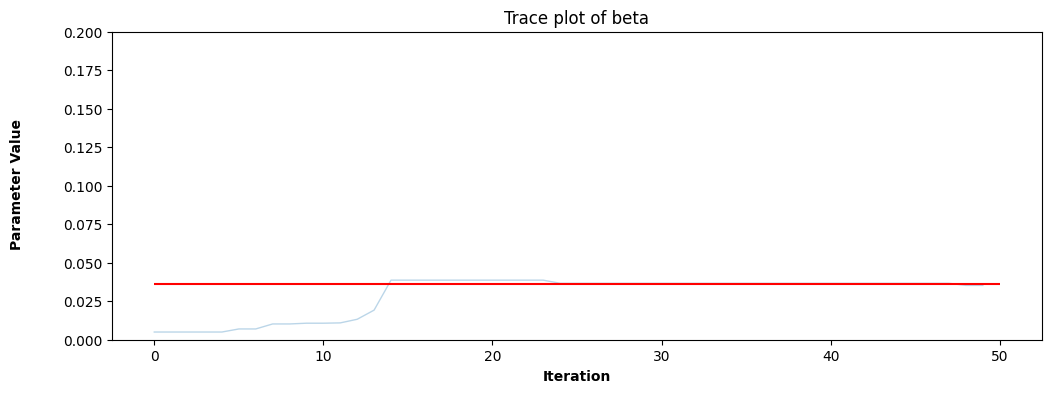

In [ ]:
# @title
# Solution 1:
def trace_plot(samples):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))

    # trace plots for parameters
    ax.plot(samples, linewidth=1, alpha=0.3)

    # subtitles
    ax.set_title('Trace plot of beta')
    # axis limits
    # ax[0].set_ylim(0., 0.4)
    ax.set_ylim(0., 0.2)

    # true value lines
    ax.hlines(xmin=0, xmax=samples.shape[0], y=beta_val, color="red")

    # plot level axis labels
    plt.xlabel('Iteration', fontweight="bold")
    fig.text(0.04, 0.5, 'Parameter Value', va='center', rotation='vertical', fontweight="bold")


trace_plot(samples)

In [ ]:
# @title
# Solution 2:
acceptance_ratio = np.sum(accept)/num_samples
print(acceptance_ratio)

0.18


## Advanced exercise:
Extend this Metropolis-Hastings algorithm to a Metropolis-within-Gibbs which updates beta and an additional parameter such as gamma.

You'll have to add a prior to gamma, and think about adding a one_step function for the body of the metropolis hastings.

